<a href="https://colab.research.google.com/github/AngelCBC/titanic-ML-from-disaster/blob/main/Titanic_ML_from_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
# Set up the environment.

import numpy as np
np.random.seed(42)

# To plot pretty figures.
import matplotlib as mpl
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [91]:
%cd '/content'

/content


In [ ]:
import os

# Specific directory acces (where your kaggle.json is allocated)
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# Dataset download (you must apply to the challenge first!!)
!kaggle competitions download -c titanic

In [93]:
import pandas as pd

# Load the data.
test_csv = pd.read_csv("test.csv")
train_csv = pd.read_csv("train.csv")   
print(f"The train csv has {len(train_csv)} instances and {len(train_csv.columns)} columns")
train_csv.head()

The train csv has 891 instances and 12 columns


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [125]:
train_csv.info() # Some nan in "Age", "Cabin" and "Embarked" attrb
test_csv.info() # Some nan in "Age", "Fare" and "Cabin" attrb

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [126]:
# Delete some columns without apparent meaning:

def delete_columns(pandas_DF):
    col_drop = ["PassengerId", "Name", "Cabin", "Ticket"] # Cabin has too many NaN
    pandas_DF.drop(col_drop, axis=1, inplace=True)
    labels = []
    # return both data and labels in the trainin case
    if hasattr(pandas_DF, 'Survived'):
        data = pandas_DF.drop("Survived", axis=1).copy()
        labels = np.array(pandas_DF["Survived"].copy())

    # return lebels=[] in the testing case
    else:
        data = pandas_DF.copy()

    return data, labels

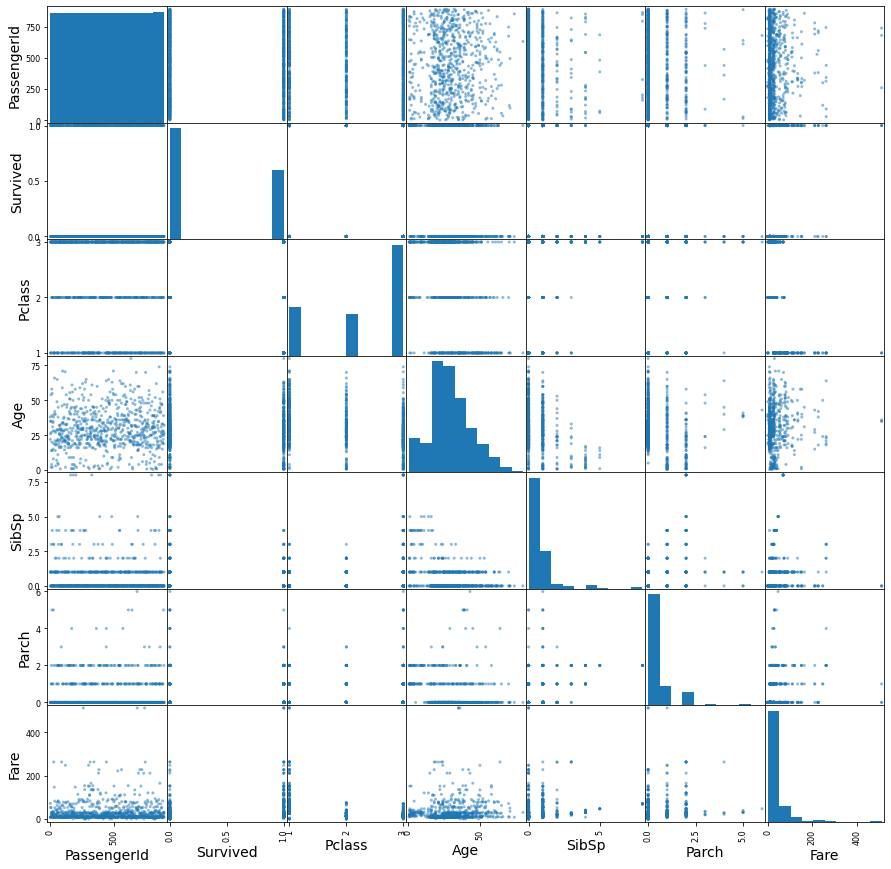

In [127]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# Data Visualization.

scatter_matrix(train_csv, figsize=(15,15))
plt.show()

In [128]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin

# Random Forest to determine which are the k-best attributes.

def best_attrbs(data, labels, k):
    # Random Forest Regression model.
    rf_reg = RandomForestRegressor()
    rf_reg.fit(data, labels)
    importance = rf_reg.feature_importances_
    return np.sort(np.argpartition(importance, -k)[-k:])

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k):
        self.k = k
    def fit(self, X, y):
        self.selection = best_attrbs(X, y, self.k)
        return self 
    def transform(self, X):
        return X[:, self.selection]

In [130]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


train = train_csv.copy()
X_train, y_train = delete_columns(train)

# Distinction between categorical and numerical attrbs.
cat_attrb = ["Sex", "Embarked"]
num_attrb = list(X_train.drop(cat_attrb, axis=1))


sub_pipeline = ColumnTransformer([
                ("numeric", Pipeline([ # Replace nan and stdscaler of num:
                        ("imputer", SimpleImputer()), 
                        ("std", StandardScaler()),]), num_attrb), 
                ("categorical", Pipeline([ # Replace nan and encode cat:
                        ("imputer", SimpleImputer(strategy="most_frequent")),
                        ("encoder", OrdinalEncoder()),]),cat_attrb),])

pipeline = Pipeline([ # Selection of the k-best features and RFClassifier:
                ("preprocessing", sub_pipeline), 
                ("attrb_selection", FeatureSelector(k=1)),
                ("classifier", RandomForestClassifier(random_state=42))])

# Dict of parameters for the RandomizedSearchCV.
parameters = {
    "attrb_selection__k": list(range(7)),
    "classifier__n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)],
    "classifier__max_features": ['auto', 'sqrt'],
    "classifier__max_depth": [int(x) for x in np.linspace(10, 110, num = 11)],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__bootstrap": [True, False],}

# Initialization of the RandomizedSearchCV.
rnm_search = RandomizedSearchCV(pipeline, parameters, cv=5, return_train_score=True,
                                verbose=3, scoring="neg_mean_squared_error", n_iter=1000)
# Train the searching.
#rnm_search.fit(X_train, y_train)

In [22]:
print("The best parameters for the RFC are:", rnm_search.best_params_)

The best parameters for the RFC are: {'classifier__n_estimators': 1345, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'auto', 'classifier__max_depth': 10, 'classifier__bootstrap': True, 'attrb_selection__k': 4}


In [102]:
# Best parameters found for the pipeline.
best_params = {'classifier__n_estimators': 1345, 'classifier__min_samples_split': 5, 
    'classifier__min_samples_leaf': 1, 'classifier__max_features': 'auto',
    'classifier__max_depth': 10,'classifier__bootstrap': True,
    "attrb_selection__k": 4}

pipeline.set_params(**best_params) # Set the best parameters found.
pipeline.fit(X_train, y_train) # Fit the training data.

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
               

In [103]:
from sklearn.metrics import accuracy_score

# Accuracy in the classification of the training data.
train_acc = accuracy_score(y_train, pipeline.predict(X_train))

print("The accuracy in the training set is:", train_acc)

The accuracy in the training set is: 0.9147025813692481


In [117]:
# Prediction of the testing labels.

test = test_csv.copy()
X_test, _ = delete_columns(test)
y_pred_test = list(pipeline.predict(X_test))

In [118]:
# CSV submission file creation.

submission = pd.DataFrame({"Survived": y_pred_test}, 
                          index=test_csv["PassengerId"])
submission.to_csv('titanic_submission.csv')
submission.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [119]:
# Submit to the challenge.

!kaggle competitions submit -c titanic -f titanic_submission.csv -m "RFC using randomSearch and FeatureSelection"

100% 2.77k/2.77k [00:02<00:00, 971B/s]
Successfully submitted to Titanic - Machine Learning from Disaster

In [ ]:
# The test set obtined a 0.77033 acc.